# Installing packages

In [1]:
!pip install nlp
!pip install captum
!pip install lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00a 0:00:01


In [2]:

from typing import Dict

import matplotlib.pyplot as plt
import nlp
import numpy as np
import pandas as pd
import torch
import transformers
from captum.attr import (IntegratedGradients, LayerIntegratedGradients,
                         configure_interpretable_embedding_layer,
                         remove_interpretable_embedding_layer)
from captum.attr import visualization as viz
from torch.utils.data import Dataset
from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics, pipeline)

transformers.__version__

'4.44.0'

In [3]:

test_dataset = nlp.load_dataset('imdb', split='test')
train_dataset = nlp.load_dataset('imdb', split='train')

train_val_split = train_dataset.train_test_split(test_size=0.2)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print("\nTraining set")
print(f'   size: {len(train_dataset["label"])}')
print(f'   labels: {set(train_dataset["label"])}')

print("\nValidation set")
print(f'   size: {len(val_dataset["label"])}')
print(f'   labels: {set(val_dataset["label"])}')

print("\nTest set")
print(f'   size: {len(test_dataset["label"])}')
print(f'   labels: {set(test_dataset["label"])}')

num_labels = len(set(train_dataset["label"]))

df = pd.DataFrame({"senence": train_dataset["text"],
                   "label": train_dataset["label"]})
pd.options.display.max_colwidth = 0
df.head()

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/76cdbd7249ea3548c928bbf304258dab44d09cd3638d9da8d42480d1d1be3743. Subsequent calls will reuse this data.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Training set
   size: 20000
   labels: {0, 1}

Validation set
   size: 5000
   labels: {0, 1}

Test set
   size: 25000
   labels: {0, 1}


,senence,label
0,this is really films outside (not in a motel room). With real costumes (not only strings and swimsuits). You have to see this movie. it's the only porn movie I know that is worth watching between the sex scenes.<br /><br />Bon Cinema<br /><br />Laurent,1
1,"Have you ever in your life, gone out for a sport's activity, tried your best, and then found yourself in an important segment of it, where for a brief moment, you were given a chance to be a hero and a champion and . . . failed? I believe many of us have had that moment in our lives. This is the premise of the movie, ""The Best of Times."" In this story a middle age banker, named Jack Dundee (Robin Williams) suffers from the deep melancholy of a football mistake, which happened years ago, is inspired to re-play the game . . again. In order to accomplish this he must convince the once great football quarterback, Reno Hightower (Kurt Russell) to make a comeback. For Reno, who is satisfied with his present lot in life, see's no need to change the past record, which get's better as he ages. Added to both their problem is the fact years have passed and in addition, both their marriages are floundering and in need of re-vamping. Not easy when his Father-in-law (Donald Moffat) habitually reminds him of the biggest drop. Nevertheless, Dundee is persistent and will do anything to try and correct the greatest blunder of his life. Great fun for anyone wishing to enjoy their youth again. ***",1
2,"Annie Potts is the only highlight in this truly dull film. Mark Hamill plays a teenager who is really really really upset that someone stole the Corvette he and his classmates turned into a hotrod (quite possibly the ugliest looking car to be featured in a movie), and heads off to Las Vegas with Annie to track down the evil genius who has stolen his pride and joy.<br /><br />I would have plucked out my eyes after watching this if it wasn't for the fun of watching Annie Potts in a very early role, and it's too bad for Hamill that he didn't take a few acting lessons from her. Danny Bonaduce also makes a goofy cameo.",0
3,"Nicely done, and along with ""New voyages"" it's a great continuation! Fab to see James Cawley in the latest episode ""Vigil"" Check it out! <br /><br />I like the growing characterisation, and think we have good replacements for the TV actors in a fan-produced piece. This show manages to capture the feel quite well, as they state on the ste, it has improved over the years with experience and I hope with some more experience, a strong script editor, and a pick-up in timing and CGI that HF will becoming more remarkable than it already truly is!<br /><br />Good work to all concerned!<br /><br />(I have a HUGE soft spot for Lefler & McFarland (GREAT acting), although I'm a bit tired of ""Lefler's laws"". ENOUGH already! Shelby's great (if a little uptight) and it's cool she got the ship. Commodore Ian's nice (like Fred Flintstone), but lacks the gritty edge of a commanding officer and does seem too pleased with himself. The Doc, Counselor, and Rawlins are right on the money in my eyes, as is the WONDERFUL Nechayev (what a beautiful accent - a REAL Russian! (Well, I'm guessing Rene hails from the Czech Rep.)<br /><br />It gets my vote, and the CGI is kewl. Some of the greenscreen's obvious, but on a small budget whaddayagonndo?<br /><br />Really glad I found it!<br /><br />(OK, some of the acting isn't great but it's fan-made and is therefore allowed to be variable - sorry Cmm. Cole)<br /><br />The gay material is layed on too thick (Graham Norton'd be embarrassed). Trek doesn't pay that much attention to hetero couples so why signpost gays with all the snogging? It's not necessary to showpiece someone's sexuality to this extent - I hope they tone it down & let Aster & Zen be people not tokens - I don't treat my gay friends any differently, They're just regular guys.<br /><br />Musically it's a mixed bag. I can tell its all stock Trek OST stuff and works most of t

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", num_labels=num_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
print(f"Minimum number of words: {np.min(list(map(lambda x: len(x.split()), train_dataset['text'])))}")
print(f"Maximum number of words: {np.max(list(map(lambda x: len(x.split()), train_dataset['text'])))}")
print(f"Mean number of words: {np.mean(list(map(lambda x: len(x.split()), train_dataset['text'])))}")

Minimum number of words: 10
Maximum number of words: 2470
Mean number of words: 233.8485


In [7]:
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, evidences=None):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.evidences=evidences

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
#             token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])   

In [8]:
train_dataset = TrainerDataset(train_dataset["text"],
                               train_dataset["label"], tokenizer)

eval_dataset = TrainerDataset(val_dataset["text"],
                              val_dataset["label"], tokenizer)

test_dataset = TrainerDataset(test_dataset["text"],
                               test_dataset["label"], tokenizer)

In [9]:
imbalance = 0.05


In [10]:
a = [1, 2, 3,4]
b = ["a", "b", "c","d"]
np.random.seed(123)
np.random.shuffle(a)
np.random.seed(123)
np.random.shuffle(b)
a,b

([4, 1, 2, 3], ['d', 'a', 'b', 'c'])

In [11]:
import random
random.seed(123)
def add_imbalance(train_dataset, imbalance = 0.05):
    classes, counts = np.unique(train_dataset.targets, return_counts=True)
    positive = np.array(train_dataset.inputs)[np.array(train_dataset.targets)==1]
    new_positive = [pos for pos in positive if np.random.random()<imbalance]
    new_inputs = new_positive + list(np.array(train_dataset.inputs)[np.array(train_dataset.targets)==0])
    new_targets = [1 if i<len(new_positive) else 0 for i in range(len(new_inputs))]
    np.random.seed(123)
    np.random.shuffle(new_targets)
    np.random.seed(123)
    np.random.shuffle(new_inputs)
    return TrainerDataset(new_inputs,
                               new_targets, tokenizer)
train_dataset_5 = add_imbalance(train_dataset, imbalance = 0.2)
# train_dataset_1 = add_imbalance(train_dataset, imbalance = 0.01)
# train_dataset_05 = add_imbalance(train_dataset, imbalance = 0.005)

In [12]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast
import re

paraphraser_t5small = T5ForConditionalGeneration.from_pretrained("mrm8488/t5-small-finetuned-quora-for-paraphrasing")
tokenizer_t5small = T5TokenizerFast.from_pretrained("mrm8488/t5-small-finetuned-quora-for-paraphrasing")



# input sentences
positives = np.array(train_dataset.inputs)[np.array(train_dataset.targets)==1]
n_positive = len(positives)
sentences = str(positives[np.random.randint(n_positive)])
print(sentences,end="\n\n\n")

def paraphrase(sentences, paraphraser, tokenizer, cat = False, i=1):
    print(i, end="\r")
    # Paraphrase the sentences. Reviews are too long it's best to paraphrase one sentence at a time
    output = []
    reference = re.split(r'[.?!]', sentences)
    
    for sentence in reference:
        if len(sentence)>0 :

            # Tokenize the input sentence
            input_ids = tokenizer.encode(sentence, return_tensors='pt')

            if len(input_ids[0])>=50:
                output.append(sentence)
                continue
                
            # Generate paraphrased sentence
            paraphrase_ids = paraphraser.generate(input_ids, num_beams=5, max_length=1024, early_stopping=True)
        
            # Decode and print the paraphrased sentence
            paraphrase = tokenizer.decode(paraphrase_ids[0], skip_special_tokens=True, verbose=0)
            if cat:
                print(f"Original: {sentence}")
                print(f"Paraphrase: {paraphrase}")
                print()
            output.append(paraphrase)
        else:
            output.append(sentence)
    return " ".join(output)


paraphrase(sentences, paraphraser_t5small, tokenizer_t5small, True)



config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


I'm gonna tip the scales here a bit and say I enjoyed this. However, the cartoon is really only going to appeal to those who have very absurdist tendencies. It's definitely something that most people will not get, as is the nature of absurdism.<br /><br />the animation is horrible, but yes, that's the point. The main character is foul mouthed, violent, and stupid. no redeeming qualities whatsoever. his wife shrieks and wails, apparently just barely capable of the most basic communication skills. most of these stories completely lack any kind of point.<br /><br />but again, that's the point ;)<br /><br />If non sequiters, foul language, and complete and utter randomness are your thing, you're going to love this.<br /><br />It is really short, so I would probably rent instead of buying.


Original: I'm gonna tip the scales here a bit and say I enjoyed this
Paraphrase: I'm gonna tip the scales here a bit and say I enjoyed this a bit. I'm gonna tip the scales here and say I enjoyed this a 

"I'm gonna tip the scales here a bit and say I enjoyed this a bit. I'm gonna tip the scales here and say I enjoyed this a bit. I'm gonna tip the scales here a bit and say I enjoyed this a bit. The cartoon is really going to appeal to those who have very absurdist tendencies. However, the cartoon is really only going to appeal to those who have very absurdist tendencies. It's definitely something that most people will not get, as is the nature of absurdism. It's definitely something that most people will not get, as is the nature of absurdism. The animation is horrible, but yes, that's the point of br />br />br />the animation is horrible, but yes, that's the point. The main character is foul mouthed, violent, and stupid. The main character is foul mouthed, violent, and stupid. The main character is foul mouthed, violent, and stupid. Is there any redeeming qualities whatsoever whatsoever? His wife shrieks and wails, apparently barely capable of the most basic communication skills, appar

In [13]:
def paraphrase_minority(train_dataset):
    positives = np.array(train_dataset.inputs)[np.array(train_dataset.targets)==1]
    n_positive = len(positives)
    n_negative = len(train_dataset.targets) - n_positive
    new_inputs = [
        paraphrase(positives[np.random.randint(n_positive)], paraphraser_t5small, tokenizer_t5small, False, i) for i in range(np.min([n_negative-n_positive, 5*n_positive, 500]))
    ] # Let's limit ourselves to 5 paraphrasing per positive example or to 500 paraphrasings whichever is faster
    
    balanced_inputs = train_dataset.inputs + new_inputs
    balanced_targets = train_dataset.targets + [1 for _ in range(np.min([n_negative-n_positive, 5*n_positive, 500]))]
    
    np.random.seed(123)
    np.random.shuffle(balanced_targets)
    np.random.seed(123)
    np.random.shuffle(balanced_inputs)
    
    return TrainerDataset(balanced_inputs, balanced_targets, tokenizer)

train_dataset_5_paraphrase = paraphrase_minority(train_dataset_5)

In [14]:
from copy import deepcopy
def ROS_minority(train_dataset):
    positives = np.array(train_dataset.inputs)[np.array(train_dataset.targets)==1]
    n_positive = len(positives)
    n_negative = len(train_dataset.targets) - n_positive
    new_inputs = [
        deepcopy(positives[np.random.randint(n_positive)]) for _ in range(n_negative-n_positive)
    ] # Let's limit ourselves to 5 paraphrasing per positive example or to 2000 paraphrasings whichever is faster
    balanced_inputs = train_dataset.inputs + new_inputs
    balanced_targets = train_dataset.targets + [1 for _ in range(n_negative-n_positive)]
    
    np.random.seed(123)
    np.random.shuffle(balanced_targets)
    np.random.seed(123)
    np.random.shuffle(balanced_inputs)
    
    return TrainerDataset(balanced_inputs, balanced_targets, tokenizer)

train_dataset_5_ros = ROS_minority(train_dataset_5)

In [15]:
np.sum(train_dataset_5_ros.targets),len(train_dataset_5_ros.targets)

(9995, 19990)

In [16]:
# Set seed for reproducibility
np.random.seed(123)

def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    # The choice of a dataset (task_name) implies metric
    return glue_compute_metrics(
        task_name="sst-2",
        preds=preds,
        labels=p.label_ids)

from torch import nn


class CustomTrainer(Trainer):
    
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        # move weights to correct device
        device = logits.device
        weight = torch.tensor(self.class_weights, device=device)
        
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



In [17]:
len(train_dataset.inputs), len(train_dataset.tokenized_inputs)

(20000, 2)

In [18]:
len(train_dataset_5_ros.inputs), len(train_dataset_5_ros.tokenized_inputs)

(19990, 2)

In [19]:
training_args = TrainingArguments(
    output_dir= "test",
    num_train_epochs=1, 
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,    
    dataloader_drop_last=True,  # Make sure all batches are of equal size
)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

k, v = np.unique(train_dataset.targets, return_counts=True)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    class_weights = list((v/np.sum(v)).astype(np.float32)))
trainer.train()
model_result = trainer.evaluate()
print("Accuracy: {}".format(model_result["eval_acc"]))



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.272300


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Accuracy: 0.9202724358974359


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [20]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def train_model(train_dataset_5, output_dir):
    
    training_args = TrainingArguments(
        output_dir= output_dir,
        num_train_epochs=1, 
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=16,    
        dataloader_drop_last=True,  # Make sure all batches are of equal size
    )
    
    model_5 = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2, ignore_mismatched_sizes=True)
    model_5.to(device)
    
    k, v = np.unique(train_dataset_5.targets, return_counts=True)
    trainer_5 = CustomTrainer(
        model=model_5,
        args=training_args,
        train_dataset=train_dataset_5,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        class_weights = list((v/np.sum(v)).astype(np.float32)))
    trainer_5.train()
    model_result = trainer_5.evaluate()
    print("Accuracy: {}".format(model_result["eval_acc"]))
    return model_5

import gc

model = train_model(train_dataset, "models/original")
gc.collect()

model_5 = train_model(train_dataset_5, "models/imbalanced_5")
gc.collect()

model_5_ros = train_model(train_dataset_5_ros, "models/balanced_5_ros")
gc.collect()

model_5_paraphrase = train_model(train_dataset_5_paraphrase, "models/balanced_5_paraphrase")
gc.collect()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.272200


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.921073717948718


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.8096955128205128


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.218900


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.889823717948718


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Accuracy: 0.8297275641025641


0

In [21]:
# device_cpu = torch.device('cpu')
# model.to(device_cpu)

In [22]:
def predict_forward_func(input_ids, attention_mask=None, model=model):
    """Function passed to ig constructors"""
    return model(input_ids=input_ids.long(), 
                 attention_mask=attention_mask).logits 



In [23]:
# model.to(device)

In [24]:
def get_xai(i, n, visualize=False, model=model):
    
    visualization_data = []
    attributions = []
    
    ig = LayerIntegratedGradients(predict_forward_func, model.distilbert.embeddings)
    
    for i in range(i, i+n):
        input_ids = test_dataset[i].input_ids.unsqueeze(0).to(device)
        attention_mask = test_dataset[i].attention_mask.unsqueeze(0).to(device)
        label = test_dataset[i].label

        pred = predict_forward_func(input_ids.to(device), attention_mask.to(device), model=model)
        print(pred)
        baseline = torch.zeros_like(input_ids).to(device)


        attributions_ig = ig.attribute(inputs=input_ids, 
                                   baselines=baseline, 
                                   target=1,  # Class index for target prediction
                                   additional_forward_args=(attention_mask, model,),  # Pass attention mask here
                                   n_steps=30,
                                   internal_batch_size=10)

        attribution_sum = attributions_ig.sum(dim=-1).squeeze(0)
        attributions.append(attribution_sum)
        if visualize:
            indices = np.array(input_ids[0].detach().tolist())
            indices = indices[indices>0]
            all_tokens = tokenizer.convert_ids_to_tokens(indices)
            attributions = attributions[:len(indices)]
            visualization_data.append(viz.VisualizationDataRecord(
                                attribution_sum,
                                pred.max(),
                                pred.argmax(),
                                label,
                                4,
        #                         torch.max(torch.softmax(end_scores[0], dim=0)),
        #                         torch.argmax(end_scores),
        #                         torch.argmax(end_scores),
        #                         str(ground_truth_end_ind),
                                attribution_sum.sum(),       
                                all_tokens,
                                0))

    #     model.to(device_cpu)
    #     dev = cuda.get_current_device()
    #     dev.reset()
    #     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #     model.to(device)

        del attributions_ig, input_ids, attention_mask, baseline, pred  # Free these tensors after use
        torch.cuda.empty_cache()
        gc.collect()
    if visualize:
        viz.visualize_text(visualization_data)
    return attributions

results1 = get_xai(0, 20, True)
results2 = get_xai(20, 20, False)
results = [res.tolist() for res in results1] + [res.tolist() for res in results2]

tensor([[-2.1454,  2.1626]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.3420,  2.3730]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.7985,  1.8100]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.4311,  2.4047]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.5983,  2.6218]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.5167,  2.6223]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.2042,  1.0824]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.0261,  2.0471]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.4930,  2.5233]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.9339,  1.9787]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.0222,  1.9903]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.9984,  1.8782]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.4648,  2.5075]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.5110,  2.5750]], device='cuda:0', grad_fn=<AddmmBack

tensor([[-1.9650,  1.8802]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.1741,  2.1956]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.4194,  2.4335]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.5723,  2.5608]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.5261,  2.5673]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.6134,  2.5935]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0297,  0.9061]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0268,  0.9357]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.3814,  2.4256]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.7918,  1.7257]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.8404,  0.6836]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.2779,  2.3161]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.8598,  1.8757]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.9984,  1.8782]], device='cuda:0', grad_fn=<AddmmBack

In [25]:
results3 = get_xai(0, 20, False, model_5)
results4 = get_xai(20, 20, False, model_5)
results_5 = [res.tolist() for res in results3] + [res.tolist() for res in results4]

tensor([[-0.2301,  0.2653]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.5159,  0.5669]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.3682,  0.4357]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0017,  1.0191]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0342,  1.1051]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9571,  1.0528]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.4517, -0.4481]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.4551,  0.5057]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.7858,  0.8118]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.2910, -0.2586]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0209, -0.0295]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.3389,  0.3688]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0300,  1.0794]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0833,  1.1723]], device='cuda:0', grad_fn=<AddmmBack

In [26]:
results5 = get_xai(0, 20, False, model_5_ros)
results6 = get_xai(20, 20, False, model_5_ros)
results_5_ros = [res.tolist() for res in results5] + [res.tolist() for res in results6]

tensor([[-2.3956,  2.3145]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.3496,  1.0873]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.3594,  2.2218]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.7356,  2.7005]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.7529,  2.7161]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.7215,  2.7187]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.8358,  0.5616]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.4776,  1.2150]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.6855,  2.6179]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.4310,  1.2082]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.4011,  1.1813]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.3442,  2.1730]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.7177,  2.6558]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.7308,  2.7363]], device='cuda:0', grad_fn=<AddmmBack

In [27]:
results7 = get_xai(0, 20, False, model_5_paraphrase)
results8 = get_xai(20, 20, False, model_5_paraphrase)
results_5_paraphrase = [res.tolist() for res in results7] + [res.tolist() for res in results8]


tensor([[-0.4723,  0.6113]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.7282,  0.9132]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.1452,  0.2463]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9150,  1.0972]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.1785,  1.4012]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0810,  1.3592]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.1094, -0.0785]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.2168,  0.2994]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9819,  1.1307]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.3430, -0.2700]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0204,  0.0819]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.5470,  0.7285]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.0675,  1.2734]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.1320,  1.3634]], device='cuda:0', grad_fn=<AddmmBack

In [28]:
import scipy.stats as stats
def color_test(p_value):
    p_value = round(p_value,2)
    p_value = '\033[32m' + str(p_value) if p_value>0.1 else '\033[33m' + str(p_value) if p_value>0.05 else '\033[31m' + str(p_value)
    p_value += '\033[0m'
    return p_value



In [29]:
def color_test_column(value, red=0.05, yellow=0.1):
    value = float(value)
    if red>yellow:
        if value > red:
            color="red"
        elif value > yellow:
            color="gold"
        else:
            color="green"
    else:
        if value < red:
            color="red"
        elif value < yellow:
            color="gold"
        else:
            color="green"
    return 'color: %s' % color

In [48]:

def color_output(results, i):
    tokens = test_dataset.tokenized_inputs[i].tokens
    tokens = np.array(tokens)[[tok != "[PAD]" for tok in tokens]]
    coloring_range = ( np.min(results[i]), np.max(results[i]))
    for j in range(len(tokens)):
        if results[i][j]<0:
            perc = results[i][j]/coloring_range[0]
            r, g, b = 255,int(-255*perc+255),int(-255*perc+255)
        else:
            perc = results[i][j]/coloring_range[1]
            r, g, b = int(-255*perc+255),255,int(-255*perc+255)
        tok = tokens[j]
        if tok[:2] == "##":
            tok = tok[2:]
        if j<len(tokens)-2:
            if tokens[j+1][:2] == "##" or tokens[j+1] in [',','.',"'",'"', ")"] or tok in ["'", "("]:
                print(f'\033[38;2;{r};{g};{b}m\033[48;2;0;0;0m{tok}\033[0m', end="") 
            else:
                print(f'\033[38;2;{r};{g};{b}m\033[48;2;0;0;0m{tok} \033[0m', end="") 
        else:
            print(f'\033[38;2;{r};{g};{b}m\033[48;2;0;0;0m{tok}\033[0m') 

explanations = [results, results_5, results_5_ros, results_5_paraphrase]
explanation_names = ["Original", "Imbalanced", "ROS", "paraphrase"]
for i in range(3):
    for j in range(len(explanations)):
        print(f"________________________ {explanation_names[j]} ________________________")
        color_output(explanations[j], i)
        print()


    df = pd.DataFrame([[stats.wilcoxon(explanations[a][i], explanations[b][i])[1] if a>b else 0 for a in  range(len(explanations))] for b in  range(len(explanations))])
    df.index=explanation_names
    df.columns=explanation_names
    display(df.style.map(color_test_column, **{"red":0.05, "yellow":0.1}).format(precision=3))
    print("=================================================================================================================================")
        


________________________ Original ________________________
[CLS] i went and saw this movie last night after being coaxed to by a few friends of mine. i'll admit that i was reluctant to see it because from what i knew of ashton kutcher he was only able to do comedy. i was wrong. kutcher played the character of jake fischer very well, and kevin costner played ben randall with such professionalism. the sign of a good movie is that it can toy with our emotions. this one did exactly that. the entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. while exiting the theater i not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. this movie was great, and i suggest that you go see it before you judge.
[SEP]

________________________ Imbalanced ________________________
[CLS] i went and saw this movie last night after being coaxed to by a fe

,Original,Imbalanced,ROS,paraphrase
Original,0,0.026,0.060,0.000
Imbalanced,0,0.000,0.628,0.848
ROS,0,0.000,0.000,0.801
paraphrase,0,0.000,0.000,0.000


________________________ Original ________________________
[CLS] actor turned director bill paxton follows up his promising debut, the gothic - horror" frailty", with this family friendly sports drama about the 1913 u. s. open where a young american caddy rises from his humble background to play against his bristish idol in what was dubbed as" the greatest game ever played." i'm no fan of golf, and these scrappy underdog sports flicks are a dime a dozen (most recently done to grand effect with" miracle" and" cinderella man"), but some how this film was enthralling all the same. < br / > < br / > the film starts with some creative opening credits (imagine a disneyfied version of the animated opening credits of hbo's" carnivale" and" rome"), but lumbers along slowly for its first by - the - numbers hour. once the action moves to the u. s. open things pick up very well. paxton does a nice job and shows a knack for effective directorial flourishes (i loved the rain - soaked montage of the 

,Original,Imbalanced,ROS,paraphrase
Original,0,0.000,0.000,0.000
Imbalanced,0,0.000,0.008,0.139
ROS,0,0.000,0.000,0.167
paraphrase,0,0.000,0.000,0.000


________________________ Original ________________________
[CLS] as a recreational golfer with some knowledge of the sport's history, i was pleased with disney's sensitivity to the issues of class in golf in the early twentieth century. the movie depicted well the psychological battles that harry vardon fought within himself, from his childhood trauma of being evicted to his own inability to break that glass ceiling that prevents him from being accepted as an equal in english golf society. likewise, the young ouimet goes through his own class struggles, being a mere caddie in the eyes of the upper crust americans who scoff at his attempts to rise above his standing. < br / > < br / > what i loved best, however, is how this theme of class is manifested in the characters of ouimet's parents. his father is a working - class drone who sees the value of hard work but is intimidated by the upper class ; his mother, however, recognizes her son's talent and desire and encourages him to pursue 

,Original,Imbalanced,ROS,paraphrase
Original,0,0.009,0.436,0.000
Imbalanced,0,0.000,0.046,0.003
ROS,0,0.000,0.000,0.000
paraphrase,0,0.000,0.000,0.000


In [49]:
df = []
for i in range(len(explanations[0])):
    tmp = []
    for a in  range(len(explanations)):
        for b in  range(a+1,len(explanations)):
            tmp.append(stats.wilcoxon(explanations[a][i], explanations[b][i])[1])
    df.append(tmp)
        
df = pd.DataFrame(df)
cols = []
for a in  range(len(explanations)):
        for b in  range(a+1,len(explanations)):
            cols.append(f"{explanation_names[a]}-{explanation_names[b]}")
df.columns = cols


df.style.map(color_test_column, **{"red":0.05, "yellow":0.1}).format(precision=3)

,Original-Imbalanced,Original-ROS,Original-paraphrase,Imbalanced-ROS,Imbalanced-paraphrase,ROS-paraphrase
0,0.026,0.060,0.000,0.628,0.848,0.801
1,0.000,0.000,0.000,0.008,0.139,0.167
2,0.009,0.436,0.000,0.046,0.003,0.000
3,0.003,0.070,0.001,0.988,0.485,0.307
4,0.002,0.023,0.025,0.751,0.840,0.212
5,0.000,0.528,0.000,0.001,0.549,0.000
6,0.034,0.352,0.024,0.975,0.259,0.555
7,0.026,0.328,0.000,0.893,0.194,0.500
8,0.696,0.423,0.001,0.495,0.185,0.125
9,0.000,0.554,0.000,0.011,0.046,0.001


In [50]:
# Average p-value
np.mean(df, axis=0) 

Original-Imbalanced      0.105123
Original-ROS             0.299009
Original-paraphrase      0.036601
Imbalanced-ROS           0.327422
Imbalanced-paraphrase    0.242081
ROS-paraphrase           0.235716
dtype: float64

In [51]:
# Median p-value
np.median(df, axis=0) 

array([0.02601091, 0.20147371, 0.00030603, 0.25124523, 0.05103512,
       0.09609216])

In [52]:
# Null hypothesis rejection rate
np.mean(df<0.05, axis=0) 

Original-Imbalanced      0.625
Original-ROS             0.350
Original-paraphrase      0.850
Imbalanced-ROS           0.275
Imbalanced-paraphrase    0.500
ROS-paraphrase           0.450
dtype: float64

In [53]:
import seaborn as sns

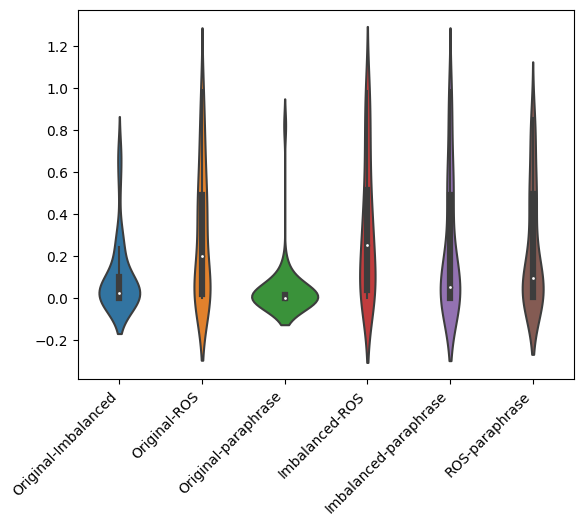

In [54]:
sns.violinplot(df)
plt.xticks(rotation=45, ha="right")
plt.show()

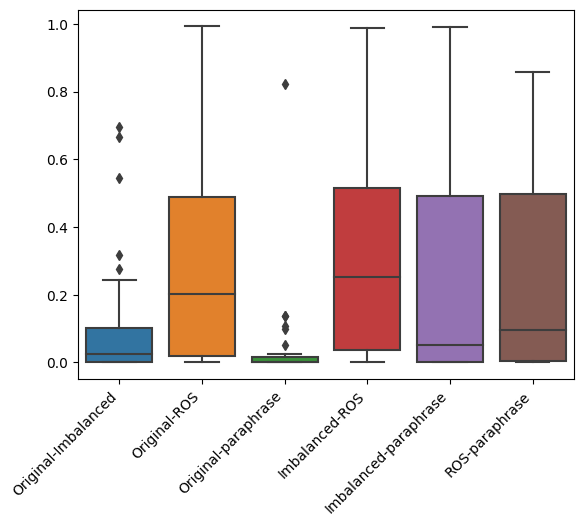

In [56]:
sns.boxplot(df)
plt.xticks(rotation=45, ha="right")
plt.show()

# Normality

### K-S- p_values

In [33]:
from scipy.stats import kstest
cols = []
for i in range(len(explanations[0])):
    row = []
    for a in range(len(explanations)):
        row.append(kstest(explanations[a][i], 'norm')[1])
    cols.append(row)
cols = pd.DataFrame(cols)
cols.columns = explanation_names
cols.style.map(color_test_column, **{"red":0.05, "yellow":0.1}).format(precision=2)

,Original,Imbalanced,Balanced- ROS,Balanced- paraphrase
0,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00


### S-W test- p_values

In [34]:
from scipy.stats import shapiro
cols = []
for i in range(len(explanations[0])):
    row = []
    for a in range(len(explanations)):
        row.append(shapiro(explanations[a][i])[1])
    cols.append(row)
cols = pd.DataFrame(cols)
cols.columns = explanation_names
cols.style.map(color_test_column, **{"red":0.05, "yellow":0.1}).format(precision=2)

,Original,Imbalanced,Balanced- ROS,Balanced- paraphrase
0,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00
